# ADD-ON to Gaussian Mixture Model vs. KMeans with Fashion-MNIST

## Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import fashion_mnist

from scipy import ndimage, misc

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Dataset Import

In [2]:
(x_train_origin, y_train), (x_test_origin, y_test) = fashion_mnist.load_data()

labelNames = ["T-shirt/Top", "Trouser", "Pullover", "Dress", 
              "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(f"Shape of x_train_origin: {x_train_origin.shape}")

Shape of x_train_origin: (60000, 28, 28)


## Sobel filter function used in the assignment

More information on the sobel method, part of the ndimage object from the scipy library, can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html). 

In [3]:
def sobel_filter(picture):
    """
    Sobel filtering of a picture along the x and y axes, with normalization
    """
    dx = ndimage.sobel(picture, 0)  # horizontal derivative
    dy = ndimage.sobel(picture, 1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize
    return np.asarray(mag, dtype=np.float32)/255.

In [4]:
def show_picture(picture):
    """
    Displays a picture and its filtered counterpart
    """
    fig = plt.figure()
    plt.gray()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    result = sobel_filter(picture)
    ax1.imshow(picture)
    ax2.imshow(result)
    plt.show()

Using the function on a test example:

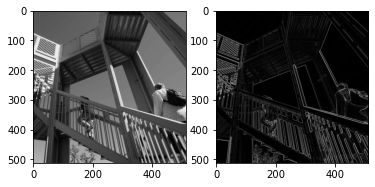

In [5]:
stock_picture = misc.ascent()

show_picture(stock_picture)

Using the function on an element form the dataset:

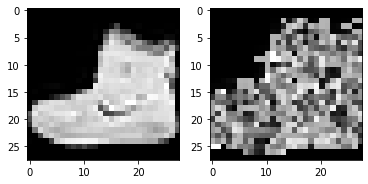

In [6]:
fmnist_picture = x_train_origin[0]

show_picture(fmnist_picture)

**We see that there is a problem with the filtering of the shoe, while the filtering of another stock image seems to work.** As such we must investigate what is wrong with the picture.

## Type Checking

Stock picture:

In [7]:
print(type(stock_picture))
print(type(stock_picture[0])) #first row of pixels
print(type(stock_picture[0][0])) # first pixel of first row

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>


Fashion-MNIST picture:

In [8]:
print(type(fmnist_picture))
print(type(fmnist_picture[0])) # first row of pixels
print(type(fmnist_picture[0][0])) # first pixel of first row

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.uint8'>


We see that the type of the pixels comprised inside the stock photo is different from the type of the fashion-MNIST photo. We test whether changing the type of each pixel of the fashion-MNIST photo from uint8 to int32 works.

In [9]:
def new_sobel_filter(picture):
    """
    (NEW) Sobel filtering of a picture along the x and y axes, with normalization
    """
    dx = ndimage.sobel(picture.astype('int32'), 0)  # horizontal derivative
    dy = ndimage.sobel(picture.astype('int32'), 1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize
    return np.asarray(mag, dtype=np.float32)/255.

In [10]:
def new_show_picture(picture):
    """
    (NEW) Displays a picture and its filtered counterpart
    """
    fig = plt.figure()
    plt.gray()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    result = new_sobel_filter(picture)
    ax1.imshow(picture)
    ax2.imshow(result)
    plt.show()

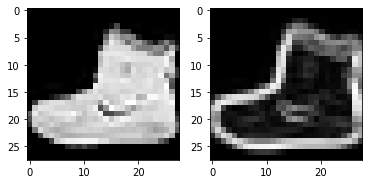

In [11]:
new_show_picture(fmnist_picture)

It works. As such, we can revamp the ``Other Explorations: Trying out MaxPooling and a Sobel Filter instead of PCA`` part from the main notebook.

## Revamping using Sobel filtering instead of PCA for data pre-processing

The goal of using the Sobel filtering instead of PCA was to see whether or not it would have an impact on the validity of a KMeans or GMM learning approaches, using the homogeneity and v-measure scores.

**Reminder**:
- The **homogeneity score** is a metric that checks whether the resulting clusters contain only data points which are members of a single class. It is *independent of the absolute values of the predicted labels*. The resulting score yields a real value between 0 and 1 with 1 standing for perfect homogeneous labeling
- The **v-measure score** takes the homogeneity score and another underlying one (the completeness score, which measures whether all data points that belong to the same class are clustered within the same cluster) and provides a weighted measure: $\frac{(1+\beta).hc}{\beta.h+c}$ with $\beta$ a factor that favors either the homogeneity or the completeness. The value of this evaluation metric is that it is independent of the number of class lavels, clusters, and of the size of the data. The resulting score yields a real value between 0 and 1 with 1 standing for perfectly complete labeling.

In [12]:
def sobel_fMNIST(dataset):
    return np.array(list(map(new_sobel_filter, dataset))).reshape(len(dataset), 784)

x_train_sobel = sobel_fMNIST(x_train_origin)
x_test_sobel = sobel_fMNIST(x_test_origin)

print(x_train_sobel.shape, x_test_sobel.shape)

(60000, 784) (10000, 784)


In [13]:
def run_kmeans(x_train, x_test, y_test, n=10):
    """
    Runs a KMeans model on the dataset
    """
    model = KMeans(n_clusters=n, random_state=0).fit(x_train)
    label_predictions = model.predict(x_test)
    kmeans_h_score = homogeneity_score(y_test, label_predictions)
    kmeans_v_score = v_measure_score(y_test, label_predictions)
    print(f"KMeans with {n} clusters yields a {round(kmeans_h_score,3)} homogeneity score " +
          f"and a {round(kmeans_v_score,3)} v-measure score")
    return label_predictions

In [14]:
def run_gmm(x_train, x_test, y_test, n=10, cov="full", init_params="kmeans"):
    """
    Runs a GMM model on the dataset
    """
    model = GaussianMixture(n_components=n, 
                            covariance_type=cov,
                            init_params=init_params,
                            random_state=0).fit(x_train)
    label_predictions = model.predict(x_test)
    gmm_h_score = homogeneity_score(y_test, label_predictions)
    gmm_v_score = v_measure_score(y_test, label_predictions)
    print(f"GMM with {n} clusters yields a {round(gmm_h_score,3)} homogeneity score " +
          f"and a {round(gmm_v_score,3)} v-measure score")
    return label_predictions

In [15]:
def visualize_clusters(predictions, y_test, labels):
    """
    Visualizes the clustering resulting from the training.
    """
    clusters={}
    for i in range(10):
        clusters[i]=[0]*10

    for index, item in enumerate(predictions):
        clusters[item][y_test[index]] += 1

    for i in range(len(clusters)):
        fig = plt.figure(figsize=(10,3))
        plt.bar(labels, clusters[i], color="purple", width=0.4)
        plt.title(f"Amount of items of a specific label assigned to cluster {i}")
        plt.show()

In [16]:
kmeans_label_predictions = run_kmeans(x_train_sobel, x_test_sobel, y_test)

KMeans with 10 clusters yields a 0.516 homogeneity score and a 0.519 v-measure score


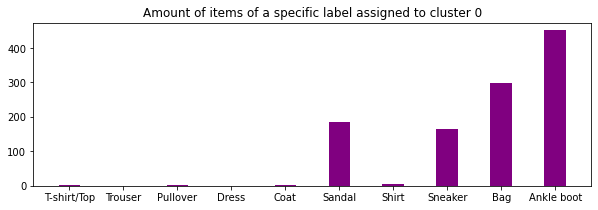

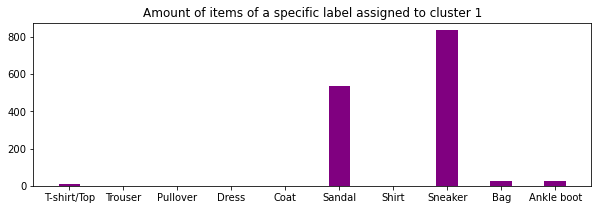

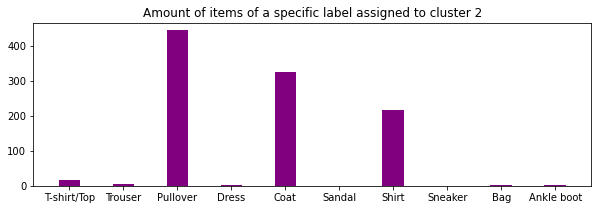

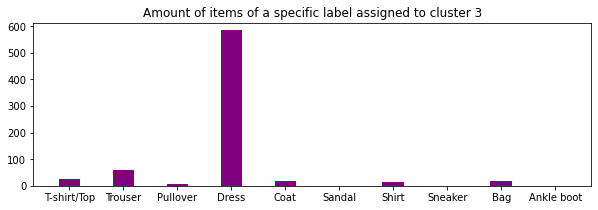

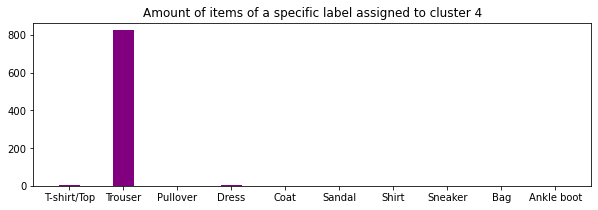

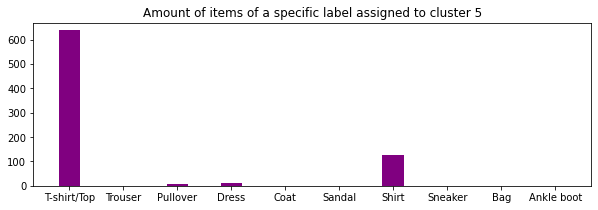

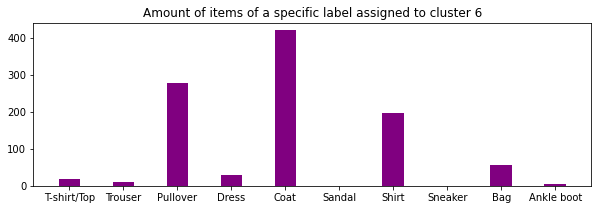

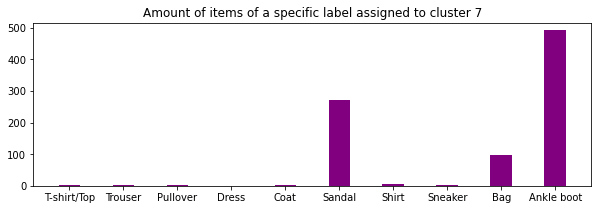

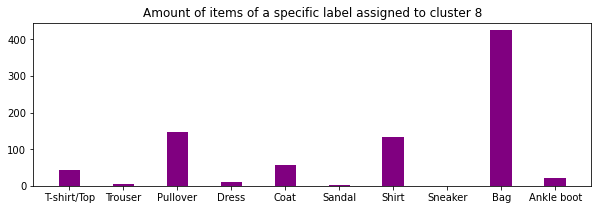

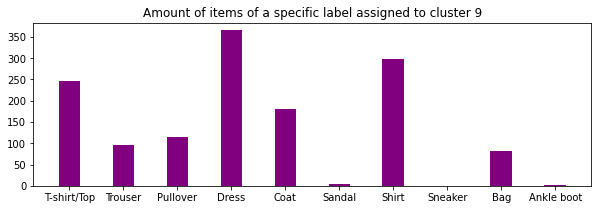

In [17]:
visualize_clusters(kmeans_label_predictions, y_test, labelNames)

We see that the results obtained are marginally better than the assignment model that used PCA, which yielded a homogeneity score of 0.493 (Sobel KMeans yields 0.516) and a v-measure score of 0.505 (Sobel KMeans yields 0.519).

<u>**Interesting Note**:</u> Though using Sobel filtering results is seemingly worst clustering for bags and shoe-type items, **the use of filtering solves the Trousers/Dresses separation that PCA failed at** (see clusters 3 and 4 which clearly separate trousers from dresses). 

In [18]:
gmm_label_predictions = run_gmm(x_train_sobel, x_test_sobel, y_test)

GMM with 10 clusters yields a 0.514 homogeneity score and a 0.519 v-measure score


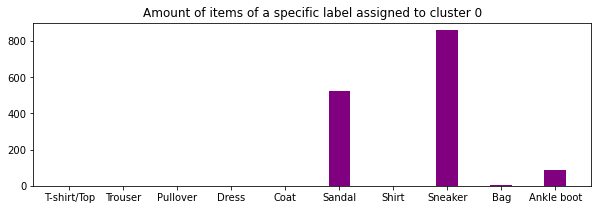

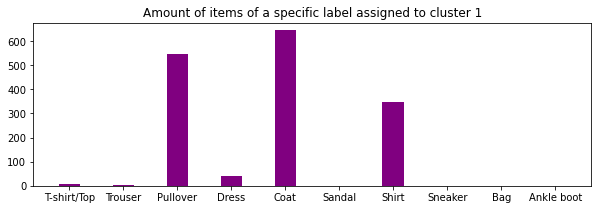

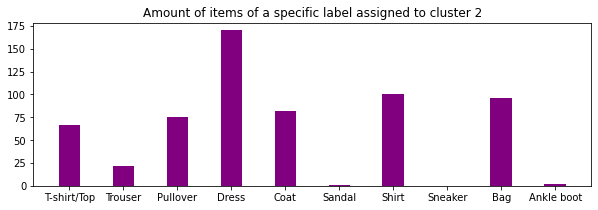

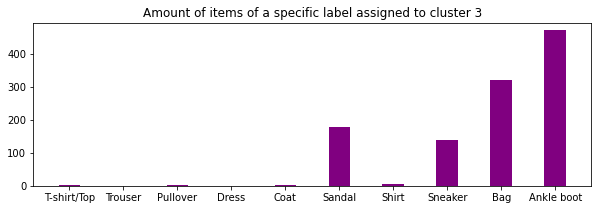

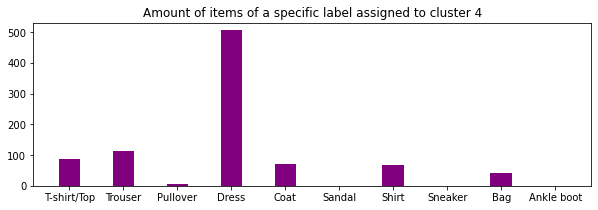

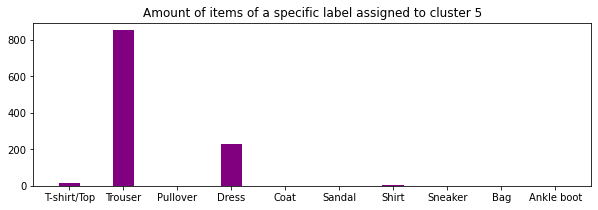

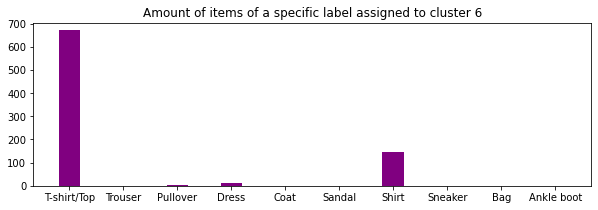

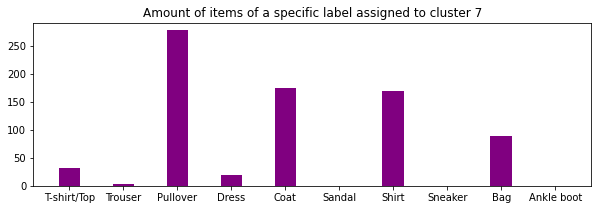

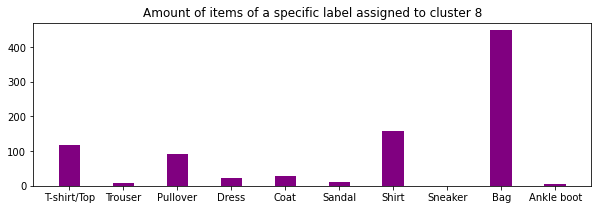

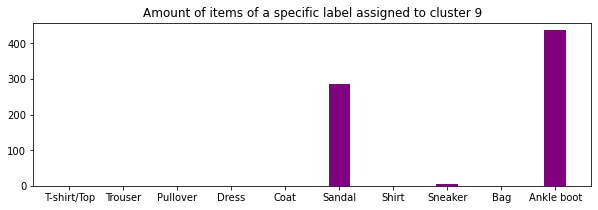

In [19]:
visualize_clusters(gmm_label_predictions, y_test, labelNames)

We see that the results obtained are marginally worse than the assignment model that used PCA, which yielded a homogeneity score of 0.548 (Sobel GMM yields 0.514) and a v-measure score of 0.555 (Sobel GMM yields 0.519).

The Sobel GMM seems to yield scores closer to the Sobel KMeans than the PCA GMM.

<u>**Interesting Note**:</u> Using Sobel filtering results seems to **solve the Trousers/Dresses separation that PCA failed at** (see clusters 4 and 5 which clearly separate trousers from dresses) **albeit in a worse fashion than Sobel KMeans**.

## Comparing the Sobel GMM procedures to the results of the assignment

We recall the results we obtained for the GMM:

| Model  number | k components | Covariance parameter | Initialization parameter | Homogeneity score  (test set) | V-measure score (test set) |
|---|---|---|---|---|---|
| 11  | 12 | tied | kmeans | 0.618 | 0.606 |
| 19  | 14 | tied | kmeans | 0.633 | 0.608 |
| 35  | 18 | tied | kmeans | 0.637 | 0.589 |
| 59  | 24 | tied | kmeans | 0.642 | 0.563 |
| 91  | 32 | tied | kmeans | 0.642 | 0.541 |
| 121 | 40 | full | kmeans | 0.669 | 0.537 |

We want to see how it compares with the sobel.

In [20]:
model = {11:{"n":12,"covariance_type":"tied","init_params":"kmeans"},
         19:{"n":14,"covariance_type":"tied","init_params":"kmeans"},
         35:{"n":18,"covariance_type":"tied","init_params":"kmeans"},
         59:{"n":24,"covariance_type":"tied","init_params":"kmeans"},
         91:{"n":32,"covariance_type":"tied","init_params":"kmeans"},
         121:{"n":40,"covariance_type":"full","init_params":"kmeans"}}

for model in model.values():
    print(f"Model to be run: {model}")
    run_gmm(x_train_sobel, x_test_sobel, y_test,
            n=model["n"], cov=model["covariance_type"],
            init_params=model["init_params"])

Model to be run: {'n': 12, 'covariance_type': 'tied', 'init_params': 'kmeans'}
GMM with 12 clusters yields a 0.497 homogeneity score and a 0.488 v-measure score
Model to be run: {'n': 14, 'covariance_type': 'tied', 'init_params': 'kmeans'}
GMM with 14 clusters yields a 0.491 homogeneity score and a 0.468 v-measure score
Model to be run: {'n': 18, 'covariance_type': 'tied', 'init_params': 'kmeans'}
GMM with 18 clusters yields a 0.53 homogeneity score and a 0.482 v-measure score
Model to be run: {'n': 24, 'covariance_type': 'tied', 'init_params': 'kmeans'}
GMM with 24 clusters yields a 0.577 homogeneity score and a 0.498 v-measure score
Model to be run: {'n': 32, 'covariance_type': 'tied', 'init_params': 'kmeans'}
GMM with 32 clusters yields a 0.6 homogeneity score and a 0.488 v-measure score
Model to be run: {'n': 40, 'covariance_type': 'full', 'init_params': 'kmeans'}
GMM with 40 clusters yields a 0.635 homogeneity score and a 0.517 v-measure score


As we see, the GMM using the Sobel filter are not outperforming the results obtained using the PCA dimensionality reduction.